## The Highly Adaptive LASSO and the `hal9001` R package

## Lab 10 for PH 290: Targeted Learning in Biomedical Big Data

### Author: [Nima Hejazi](https://nimahejazi.org)

### Date: 21 March 2018

# I. The Highly Adaptive LASSO (HAL)

### Recommended Reading

* Benkeser, D, and van der Laan, MJ (2016). "The Highly Adaptive Lasso Estimator." IEEE International Conference on Data Science and Advanced Analytics. (http://ieeexplore.ieee.org/abstract/document/7796956/)
* R package: Coyle, JR, and Hejazi, NS (2018). "hal9001: A fast and scalable Highly Adaptive LASSO." (https://github.com/jeremyrcoyle/hal9001)

### What's HAL All About?

"Estimation of a regression function is a common goal of statistical learning. We propose a novel _nonparametric regression estimator_ that, in contrast to many existing methods, does not rely on _local smoothness assumptions_ nor is it constructed using _local smoothing techniques_. Instead, our estimator respects global smoothness constraints by virtue of falling in a class of right-hand continuous functions with left-hand limits that have variation norm bounded by a constant. Using empirical process theory, we establish a fast minimal rate of convergence of our proposed estimator and illustrate how such an estimator can be constructed using standard software." -excerpted from Benkeser & vdL (2016).

### Why Care About Prediction?

* Consider observed data $O = (X, Y)$, where $X$ is a set of covariates and $Y$ a vector outcome of interest.
* Let us further write $O \sim P_0 \in \mathcal{M}^{NP}$, where $P_0$ is the true distribution of the observed data $O$, contained in the nonparametric (infinite-dimensional) statistical model $\mathcal{M}^{NP}$.
* Let the _target parameter_ be the prediction function $\psi_0$ s.t. we have $\psi_0 \in \Psi$, a class of prediction functions that minimize the average of a scientifically relevant loss function (e.g., negative log-likelihood for binary outcomes).
* Thus, our goal is to estimate $\Psi(P_0)(X) = \text{argmin}_{\psi \in \Psi} E_{P_0}{L(\psi)(X, Y)}$ for an arbitrary loss function $L(\psi)$.

### How Can Prediction Go Wrong?

* "Parametric and semiparametric methods for estimating the conditional mean assume its form is known up to a finite number of parameters."
* Consider GLMs, which express the conditional mean as a transformation of a linear function of the conditioning variables - e.g., $E(Y \mid X) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \ldots$
* Parametric methods suffer from a large bias when the assumed functional form is different from the true conditional mean (e.g., $E(Y \mid X) = \beta_0 + \beta_i X_1 X_2 + \beta_j X_1^2 + \beta_k X_2^3 + \ldots$).
* Even nonparametrics is plagued by assumptions: "For example, many methods assume $\psi_0$ has nearly constant, linear, or low-order polynomial behavior for all points sufficiently close to each other in a given metric."

### Theory and Properties of HAL

* "We assume that the true conditional mean function is right-hand continuous with left-hand limits (cadlag) and has variation norm smaller than a constant $M$. These are exceedingly mild assumptions that are expected to hold in almost every practical application."
* We make two key smoothness assumptions about $\psi_0$: (1) $\psi_0$ is an element of the Banach space of d-variate cadlag functions; (2) $\psi_0$ has finite variation norm, where the variation norm is defined $\mid\mid \psi \mid\mid_{v} = \int_{[0, \tau]} \mid \psi(dx) \mid$. The definition of HAL follows directly from an alternate formulation of the variation norm...
* For any function $\psi \in D[0, \tau]$, we define the s-th section of $\psi$ as $\psi_s(x) = \psi(x_1 I(1 \in s), \ldots, x_d I(d \in s))$, which is _the function that varies along the variables in $x_s$ according to $\psi$, but sets the variables in $x_{s,c}$ equal to zero_. 
* Under the conditions above, $\psi$ admits the following representation: $$\psi(x) = \psi(0) + \sum_{s \subset \{1, \ldots, d\}} \int_{0_s}^{x_s} \psi_s(du) = \psi(0) + \sum_{s \subset \{1, \ldots, d\}} \int_{0_s}^{\tau_s} I(u \leq x_s) \psi_s(du).$$
* By approximating $\psi$ above with a discrete measure $\psi_m$ over $m$ support points, one may write $$\psi_m(x) = \psi(0) + \sum_{s \subset \{1, \ldots, d\}} \sum_{j} I(u_{s,j} \leq x_s) d\psi_{m,s,j},$$ where this approximation consists of a linear combination of basis functions with
corresponding coefficients $d\psi_{m,s,j}$ summed over $s$ and $j$.
* The following nice property follows directly from the definition of the HAL estimator: the sum of the absolute values of these coefficients gives the variation norm of $\psi_m$ - i.e., $$\mid\mid\psi_m \mid\mid_v = \psi(0) + \sum_{s \subset \{1, \ldots, d\}} \sum_{j} \mid d\psi_{m,s,j} \mid.$$
 


### How Does HAL Help Us?

* Since HAL has been shown to consistently estimate the true functional relation at a rate faster than $n^{−\frac{1}{4}}$ as a function of sample size $n$, whenever the true target function has finite variation norm, we are able to obtain very good convergence rates when using it as an estimator.
* The assumption of finite variation norm may be easily included in our statistical model without any concern for misspecification, since it is unlikely that the true functional relations have infinite variation as a function of the different covariates.

# II. Nonparametric Estimation / Prediction with `hal9001`

First, let's load the packages we'll be using and some core project management tools.

In [1]:
options(repr.plot.width = 5, repr.plot.height = 5)  ## resizing plots
options(scipen = 999)  ## has scientific notation ever annoyed you?

In [2]:
library(here)
library(usethis)
library(tidyverse)
library(data.table, quietly = TRUE)

here() starts at /Users/nimahejazi/Dropbox/UC_Berkeley-grad/teaching/2018_Spring/tlbbd-labs/lab_10
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.0     ✔ stringr 1.3.0
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose



In [3]:
library(earth)
library(glmnet)
library(randomForest)
library(hal9001)
library(sl3)
set.seed(385971)

Loading required package: plotmo
Loading required package: plotrix
Loading required package: TeachingDemos
Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-13

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin

hal9001 v0.1.1: A fast and scalable Highly Adaptive LASSO


We begin by simulating a simple data set and illustrating a simple execution of how to use `hal9001` for prediction.

In [4]:
n = 1000
p = 3
x <- cbind(matrix(rnorm(n * p), n, p), rbinom(n, 1, 0.61))
y <- sin(x[, 1]) * sin(x[, 2]) + x[, 1]^2 * (x[, 1] > x[, 2]) + x[, 3] * x[,4] +
     rnorm(n, mean = 0, sd = 0.3)
data <- as.data.table(cbind(x, y))
setnames(data, c(paste0("X", seq_len(p + 1)), "Y"))
head(data)

X1,X2,X3,X4,Y
0.2086134,-0.16809762,0.3635787,0,0.4550150
-0.9477350,-0.68371703,-1.2229561,0,0.1571233
0.9254026,-1.42357891,0.1638252,1,0.1943260
0.5603774,-0.09578228,1.4152984,1,1.6964338
0.6430260,1.01289165,-1.1249601,0,0.5796670
-0.9730101,0.18683905,0.3577011,0,-0.7109583


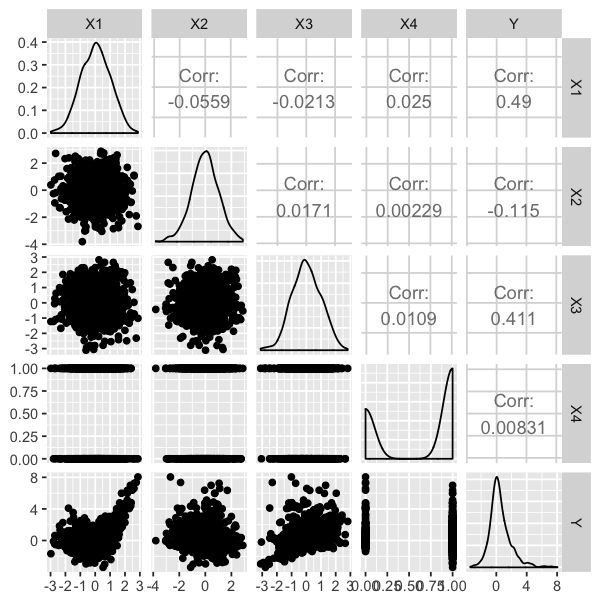

In [5]:
GGally::ggpairs(data)

**Let's try a few standard prediction algorithms**

In [6]:
# Intercept GLM
mean_fit <- mean(y)
mean_pred <- rep(mean_fit, length(y))
(mse_mean <- mean((y - mean_pred)^2))

[1] 1.991324

In [7]:
# Simple GLM
glm_fit <- glm(Y ~ ., data = data)
glm_pred <- predict(glm_fit)
(mse_glm <- mean((y - glm_pred)^2))

[1] 1.139971

In [8]:
# Ridge (L2-penalized) regression
ridge_fit <- glmnet(x = x, y = y, alpha = 0)
ridge_pred <- predict(ridge_fit, newx = x)
(mse_ridge <- mean((y - ridge_pred)^2))

[1] 1.620973

In [9]:
# Lasso (L1-penalized) regression
lasso_fit <- glmnet(x = x, y = y, alpha = 1)
lasso_pred <- predict(lasso_fit, newx = x)
(mse_lasso <- mean((y - lasso_pred)^2))

[1] 1.241301

In [10]:
# Multivariate Adaptive Regression Splines (MARS)
mars_fit <- earth(Y ~ ., data = data)
mars_pred <- predict(mars_fit)
(mse_mars <- mean((y - mars_pred)^2))

[1] 0.5473263

In [11]:
# Random Forest
rf_fit <- randomForest(Y ~ ., data = data)
rf_pred <- predict(rf_fit)
(mse_rf <- mean((y - rf_pred)^2))

[1] 0.548685

In [12]:
# Highly Adaptive LASSO (HAL)
hal_fit <- fit_hal(X = x, Y = y)
hal_pred <- predict(hal_fit, new_data = x)
(mse_hal <- mean((y - hal_pred)^2))

[1] "Good morning, Dave."


[1] 0.0840656

### Model Ensembling with `sl3`

Now that we've generate some data, we will generate an `Task` object for use with `sl3`:

In [13]:
task <- sl3_Task$new(data, covariates = c(paste0("X", seq_len(p + 1))), outcome = "Y")
task

A sl3 Task with 1000 obs and these nodes:
$covariates
[1] "X1" "X2" "X3" "X4"

$outcome
[1] "Y"

$id
NULL

$weights
NULL

$offset
NULL


**Easily and flexibly build a stack** _(n.b., this is the `sl3` idiom for the `SL.library` of `SuperLearner`)_

In [14]:
lrnr_stack <- make_learner_stack("Lrnr_mean", "Lrnr_glm_fast", "Lrnr_randomForest")
lrnr_stack

[1] "Lrnr_mean"
[1] "Lrnr_glm_fast_TRUE_Cholesky"
[1] "Lrnr_randomForest_100_TRUE_5_NULL_FALSE"
[[1]]
[1] "Lrnr_mean"

[[2]]
NULL

[[3]]
NULL


**Next, we'll train the Super Learner and predict on the observed data**

In [15]:
sl <- Lrnr_sl$new(learners = list(lrnr_stack), metalearner = Lrnr_nnls$new())
sl_fit <- sl$train(task)
preds_sl <- sl_fit$predict()
(mse_sl <- mean((y - preds_sl)^2))

[1] 0.04066958

**What's the stacked ensemble look like?**

In [16]:
sl_fit

[1] "SuperLearner:"
List of 1
 $ : chr "Stack"
[1] "Lrnr_nnls"
                                     lrnrs weights
1:                               Lrnr_mean 0.00000
2:             Lrnr_glm_fast_TRUE_Cholesky 0.00000
3: Lrnr_randomForest_100_TRUE_5_NULL_FALSE 1.03947
[1] "Cross-validated risk (MSE, squared error loss):"
                                   learner coefficients mean_risk    SE_risk
1:                               Lrnr_mean      0.00000 1.9951799 0.14827550
2:             Lrnr_glm_fast_TRUE_Cholesky      0.00000 1.1664105 0.09117183
3: Lrnr_randomForest_100_TRUE_5_NULL_FALSE      1.03947 0.2158630 0.01532222
4:                            SuperLearner           NA 0.2129381 0.01503779
      fold_SD fold_min_risk fold_max_risk
1: 0.68348784     1.2554075     3.0880768
2: 0.37317242     0.6950223     1.7927896
3: 0.04590635     0.1337699     0.2771392
4: 0.04479534     0.1417545     0.2834144

**What happens when we add HAL to the stacked ensemble?**

Yes, there's a `Lrnr_hal9001` now!

In [17]:
lrnr_stack_hal <- make_learner_stack("Lrnr_mean", "Lrnr_glm_fast", "Lrnr_randomForest",
                                     "Lrnr_hal9001")
sl_hal <- Lrnr_sl$new(learners = list(lrnr_stack_hal), metalearner = Lrnr_nnls$new())
sl_hal_fit <- sl_hal$train(task)
preds_sl_hal <- sl_hal_fit$predict()
(mse_sl_hal <- mean((y - preds_sl_hal)^2))

[1] 0.05277756

In [19]:
sl_hal_fit

[1] "SuperLearner:"
List of 1
 $ : chr "Stack"
[1] "Lrnr_nnls"
                                     lrnrs   weights
1:                               Lrnr_mean 0.0000000
2:             Lrnr_glm_fast_TRUE_Cholesky 0.0000000
3: Lrnr_randomForest_100_TRUE_5_NULL_FALSE 0.5168892
4:        Lrnr_hal9001_NULL_glmnet_10_TRUE 0.5030761
[1] "Cross-validated risk (MSE, squared error loss):"
                                   learner coefficients mean_risk    SE_risk
1:                               Lrnr_mean    0.0000000 1.9951799 0.14827550
2:             Lrnr_glm_fast_TRUE_Cholesky    0.0000000 1.1664105 0.09117183
3: Lrnr_randomForest_100_TRUE_5_NULL_FALSE    0.5168892 0.2197907 0.01535048
4:        Lrnr_hal9001_NULL_glmnet_10_TRUE    0.5030761 0.2166624 0.02211670
5:                            SuperLearner           NA 0.1862682 0.01446540
      fold_SD fold_min_risk fold_max_risk
1: 0.68348784     1.2554075     3.0880768
2: 0.37317242     0.6950223     1.7927896
3: 0.04455936     0.1359939   

### _Reminder:_ Homwork #3, Question 2: Contributing to `sl3`

**Update: Homework #3 is now officially due Friday, 06 April, by 3pm**

What learners to contribute: https://github.com/tlverse/sl3/issues/114
How do learners work: https://sl3.tlverse.org/articles/custom_lrnrs.html

Tips and best practices:
* For the `sl3` repo from https://github.com/tlverse/sl3
* Using git, create a new branch for your proposed contribution (e.g., `Lrnr_ranger`)
* Generate a template for your new learner via `sl3::write_learner_template(here::here("R", "Lrnr_ranger.R"))`
* Fill out the template based on the properties of your new learner. Try looking at already written learners to get a better idea of how to fill out the various methods slots.
* Write a set of unit tests under `tests/testthat/test_Lrnr_ranger.R` that ensure that your new learner works as intended/expected.
* For a guide on how to write unit tests properly, try looking at the numerous unit tests that already exist inside the `sl3` package.
* For background on unit testing in R, take a look here: http://r-pkgs.had.co.nz/tests.html
* The `tlverse` ecosystem uses the ["`Tidyverse` Style Guide"](http://style.tidyverse.org/). Make sure to follow the formatting guidelines for your code and for pull requests. You can use the [`styler` R package](https://cran.r-project.org/web/packages/styler/index.html) to automatically reformat your code.